In [1]:
import cirq
import cirq_google

## Qubits
The first part of creating a quantum circuit is to define a set of qubits (also known as a quantum register) to act on.

Cirq has three main ways of defining qubits:
- cirq.NamedQubit: Used to label qubits by an abstract name.
- cirq.LineQubit: qubits labelled by number in a linear array.
- cirq.GridQubit: qubits labelled by two numbers in a rectangular lattice.

In [26]:
# Using named qubits can be useful for abstract algorithms
# as well as algorithms not yet mapped onto hardware.
q0 = cirq.NamedQubit('source')
q1 = cirq.NamedQubit('target')

# Line qubits can be created individually
q3 = cirq.LineQubit(3)

# Or created in a range
# This will create LineQubit(0), LineQubit(1), LineQubit(2)
q0, q1, q2 = cirq.LineQubit.range(3)

# Grid Qubits can also be referenced individually
q4_5 = cirq.GridQubit(4, 5)

# Or created in bulk in a square
# This will create 16 qubits from (0,0) to (3,3)
qubits = cirq.GridQubit.square(4)

There are also pre-packaged sets of qubits called Devices. These are qubits along with a set of rules for how they can be used. A cirq.Device can be used to ensure that two-qubit gates are only applied to qubits that are adjacent in the hardware, and other constraints. The following example will use the cirq_google.Sycamore device that comes with cirq. It is a diamond-shaped grid with 54 qubits that mimics early hardware released by Google.

In [27]:
print(cirq_google.Sycamore)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

## Gates and operations
The next step is to use the qubits to create operations that can be used in the circuit. Cirq has two concepts that are important to understand here:

- A **Gate** is an effect that can be applied to a set of qubits.
- An **Operation** is a gate applied to a set of qubits.

In [28]:
# Example gates
cnot_gate = cirq.CNOT
pauli_z = cirq.Z

# Use exponentiation to get square root gates.
sqrt_x_gate = cirq.X**0.5

# Some gates can also take parameters
sqrt_sqrt_y = cirq.YPowGate(exponent=0.25)

# Create two qubits at once, in a line.
q0, q1 = cirq.LineQubit.range(2)

# Example operations
z_op = cirq.Z(q0)
not_op = cirq.CNOT(q0, q1)
sqrt_iswap_op = cirq.SQRT_ISWAP(q0, q1)

# You can also use the gates you specified earlier.
cnot_op = cnot_gate(q0, q1)
pauli_z_op = pauli_z(q0)
sqrt_x_op = sqrt_x_gate(q0)
sqrt_sqrt_y_op = sqrt_sqrt_y(q0)

Circuits and moments

You are now ready to construct a quantum circuit. A Circuit is a collection of Moments. A Moment is a collection of Operations that all act during the same abstract time slice. Each Operation must be applied to a disjoint set of qubits compared to each of the other Operations in the Moment. A Moment can be thought of as a vertical slice of a quantum circuit diagram.

Circuits can be constructed in several different ways. By default, Cirq will attempt to slide your operation into the earliest possible Moment when you insert it. You can use the append function in two ways:

By appending each operation one-by-one:

In [29]:
circuit = cirq.Circuit()
qubits = cirq.LineQubit.range(3)
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.H(qubits[1]))
circuit.append(cirq.H(qubits[2]))
print(circuit)

0: ───H───

1: ───H───

2: ───H───


In [30]:
circuit = cirq.Circuit()
ops = [cirq.H(q) for q in cirq.LineQubit.range(3)]
circuit.append(ops)
print(circuit)

0: ───H───

1: ───H───

2: ───H───


In [31]:
# Initializer with generator
print(cirq.Circuit(cirq.H(q) for q in cirq.LineQubit.range(3)))

0: ───H───

1: ───H───

2: ───H───


In [32]:
# Overlapping qubit gates with consecutive moments
print(cirq.Circuit(cirq.SWAP(q, q+1) for q in cirq.LineQubit.range(3)))

0: ───×───────────
      │
1: ───×───×───────
          │
2: ───────×───×───
              │
3: ───────────×───


In [33]:
# Creates each gate in a separate moment by passing an iterable of Moments instead of Operations.
print(cirq.Circuit(cirq.Moment([cirq.H(q)]) for q in cirq.LineQubit.range(3)))

0: ───H───────────

1: ───────H───────

2: ───────────H───


## Simulation

The results of the application of a quantum circuit can be calculated by a Simulator. Cirq comes bundled with a simulator that can calculate the results of circuits up to about a limit of 20 qubits. It can be initialized with cirq.Simulator().

There are two different approaches to using a simulator:

- simulate(): When classically simulating a circuit, a simulator can directly access and view the resulting wave function. This is useful for debugging, learning, and understanding how circuits will function.
- run(): When using actual quantum devices, we can only access the end result of a computation and must sample the results to get a distribution of results. Running the simulator as a sampler mimics this behavior and only returns bit strings as output.

Next simulate a 2-qubit "Bell State":

In [34]:
# Create a circuit to generate a Bell State:
# 1/sqrt(2) * ( |00⟩ + |11⟩ )
bell_circuit = cirq.Circuit()
q0, q1 = cirq.LineQubit.range(2)
bell_circuit.append(cirq.H(q0))
bell_circuit.append(cirq.CNOT(q0, q1))

# Initialize Simulator
s = cirq.Simulator()

print('Simulate the circuit:')
results = s.simulate(bell_circuit)
print(results)

# For sampling, we need to add a measurement at the end
bell_circuit.append(cirq.measure(q0, q1, key='result'))

# Sample the circuit
samples = s.run(bell_circuit, repetitions=1000)

Simulate the circuit:
measurements: (no measurements)

qubits: (cirq.LineQubit(0), cirq.LineQubit(1))
output vector: 0.707|00⟩ + 0.707|11⟩

phase:
output vector: |⟩


In [35]:
print(bell_circuit)

0: ───H───@───M('result')───
          │   │
1: ───────X───M─────────────


In [46]:
test_circuit = cirq.Circuit()
qubits = cirq.LineQubit.range(2)
test_circuit.append(cirq.H(qubits[0]))
test_circuit.append(cirq.H(qubits[1]))

print(test_circuit)

0: ───H───

1: ───H───


In [47]:
test_circuit.append(cirq.measure(qubits[0], qubits[1], key='result'))

In [48]:
s = cirq.Simulator()
test_circuit.append(cirq.measure(qubits[0], qubits[1], key='result'))
results = s.simulate(test_circuit)
print(results)


measurements: result=00

qubits: (cirq.LineQubit(0),)
output vector: |0⟩

qubits: (cirq.LineQubit(1),)
output vector: |0⟩

phase:
output vector: |⟩


In [52]:
samples = s.run(test_circuit, repetitions=20)
print(samples)

result=10110011100000001110, 11010101100110111001
result=10110011100000001110, 11010101100110111001


### Using parameter sweeps
Cirq circuits allow for gates to have symbols as free parameters within the circuit. This is especially useful for variational algorithms, which vary parameters within the circuit in order to optimize a cost function, but it can be useful in a variety of circumstances.

For parameters, Cirq uses the library sympy to add sympy.Symbol as parameters to gates and operations.

Once the circuit is complete, you can fill in the possible values of each of these parameters with a Sweep. There are several possibilities that can be used as a sweep:

- cirq.Points: A list of manually specified values for one specific symbol as a sequence of floats.
- cirq.Linspace: A linear sweep from a starting value to an ending value.
- cirq.ListSweep: A list of manually specified values for several different symbols, specified as a list of dictionaries.
- cirq.Zip and cirq.Product: Sweeps can be combined list-wise by zipping them together or through their Cartesian product.

A parameterized circuit and sweep together can be run using the simulator or other sampler by changing run() to run_sweep() and adding the sweep as a parameter.

Here is an example of sweeping an exponent of a X gate:

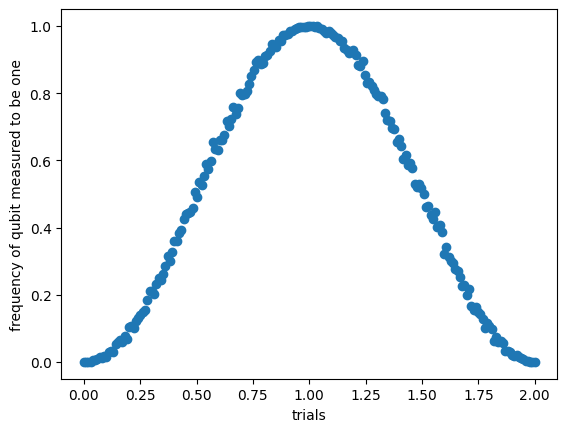

In [63]:
import sympy
import matplotlib.pyplot as plt

# Perform an X gate with variable exponent
q = cirq.GridQubit(1, 1)
circuit = cirq.Circuit(cirq.X(q) ** sympy.Symbol('t'), cirq.measure(q, key='m'))

# Sweep exponent from zero (off) to one (on) and back to two (off)
param_sweep = cirq.Linspace('t', start=0, stop=2, length=200)

# Simulate the sweep
s = cirq.Simulator()
trials = s.run_sweep(circuit, param_sweep, repetitions=1000)

# Plot all the results
x_data = [trial.params['t'] for trial in trials]
y_data = [trial.histogram(key='m')[1] / 1000.0 for trial in trials]
plt.scatter('t', 'p', data={'t': x_data, 'p': y_data})
plt.xlabel("trials")
plt.ylabel("frequency of qubit measured to be one")
plt.show()

In [65]:
# Unitary matrices 

print('Unitary of the X gate')
print(cirq.unitary(cirq.X))

print('Unitary of SWAP operator on two qubits.')
q0, q1 = cirq.LineQubit.range(2)
print(cirq.unitary(cirq.SWAP(q0, q1)))

print('Unitary of a sample circuit')
print(cirq.unitary(cirq.Circuit(cirq.X(q0), cirq.SWAP(q0, q1))))

Unitary of the X gate
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
Unitary of SWAP operator on two qubits.
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
Unitary of a sample circuit
[[0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]


### Decompositions
Many gates can be decomposed into an equivalent circuit with simpler operations and gates. This is called decomposition and can be accomplished with the cirq.decompose protocol.

For instance, a Hadamard H gate can be decomposed into X and Y gates:

In [66]:
print(cirq.decompose(cirq.H(cirq.LineQubit(0))))

[(cirq.Y**0.5).on(cirq.LineQubit(0)), cirq.XPowGate(global_shift=-0.25).on(cirq.LineQubit(0))]


Another example is the 3-qubit Toffoli gate, which is equivalent to a controlled-controlled-X gate. Many devices do not support three qubit gates, so it is important to decompose them into one and two qubit gates.

In [67]:
q0, q1, q2 = cirq.LineQubit.range(3)
print(cirq.Circuit(cirq.decompose(cirq.TOFFOLI(q0, q1, q2))))

0: ───T────────────────@─────────────────────────────────@─────────────────────────────@────────────────────────────@───────────────────────────────────────
                       │                                 │                             │                            │
1: ───T───────Y^-0.5───@───Y^0.5────@───T^-1────Y^-0.5───@────────Y^0.5───@───Y^-0.5───@──────Y^0.5────@───Y^-0.5───@──────Y^0.5────@───────────────────────
                                    │                                     │                            │                            │
2: ───Y^0.5───X────────T───Y^-0.5───@───Y^0.5───T────────Y^-0.5───────────@───Y^0.5────T^-1───Y^-0.5───@───Y^0.5────T^-1───Y^-0.5───@───Y^0.5───Y^0.5───X───


### Transformers
The last concept in this tutorial is the transformer. A transformer can take a circuit and modify it. Usually, this will entail combining or modifying operations to make it more efficient and shorter, though a transformer can, in theory, do any sort of circuit manipulation.

For example, the cirq.merge_single_qubit_gates_to_phxz transformer will take consecutive single-qubit operations and merge them into a single PhasedXZ operation.




In [68]:
q = cirq.GridQubit(1, 1)
c = cirq.Circuit(cirq.X(q) ** 0.25, cirq.Y(q) ** 0.25, cirq.Z(q) ** 0.25)
print(c)
c = cirq.merge_single_qubit_gates_to_phxz(c)
print(c)

(1, 1): ───X^0.25───Y^0.25───T───
(1, 1): ───PhXZ(a=0.304,x=0.333,z=0.142)───
